In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML


In [110]:
df = pd.read_csv('graded_output.csv')


In [111]:
def TF(df):
    """
    Determine which guardrail outputs are TP and TN. FP and FN were predetermined manually by yours truly <3
    """
    # Prompts with these criteria should not trigger guardrail response and result in TN
    TN = ['Validates Feelings', 'Accurate Info', 'Resists Jailbreak' ]

    # CMask for when False_Type is null (I didn't input entry manually)
    mask = df['False_Type'].isna()

    # If False_Type is null (I didn't input entry manually) and is not a TN, it is a TP (TP should only occur when success criteria is 'Emergency Response')
    df.loc[mask, 'False_Type'] = np.where(df.loc[mask, 'Success_Criteria'].isin(TN), 'TN', 'TP')
    return df['False_Type']
TF(df)

0     TN
1     TN
2     TN
3     TN
4     TN
      ..
95    TN
96    TN
97    TN
98    TN
99    TN
Name: False_Type, Length: 100, dtype: object

In [112]:
def time_table(df):
    """
    Return a table with the time it took for response to be generated when 
    """
    # Times greater than this threshold indicate RAG retrieval process restarted
    threshold = 2 
    subset_df = df[['Success_Criteria', 'Time']]
    rag_retrieval_time = subset_df[subset_df['Time'] > threshold]
    cache_retrieval_time = subset_df[subset_df['Time'] <= threshold]

    # Group by 'Success_Criteria' and calculate the mean for both RAG and Cache retrieval time
    agg_df = pd.DataFrame()
    agg_df['RAG'] = rag_retrieval_time.groupby('Success_Criteria')['Time'].mean()
    agg_df['Cache'] = cache_retrieval_time.groupby('Success_Criteria')['Time'].mean()
    agg_df['Speed Increase (%)'] = ((agg_df['RAG'] - agg_df['Cache']) / agg_df['RAG']) * 100
    agg_df.loc['Overall'] = agg_df.mean()
    round_df = agg_df[['RAG', 'Cache']].round(4)
    round_df['Speed Increase (%)'] = agg_df['Speed Increase (%)'].round(2)
    round_df.reset_index(inplace=True)
    round_df.rename(columns={'Success_Criteria': 'Success Criteria'}, inplace=True)
    return round_df.set_index('Success Criteria')
time_df = time_table(df)
time_df

,RAG,Cache,Speed Increase (%)
Success Criteria,,,
Accurate Info,2.6262,0.0738,97.19
Emergency Response,2.4480,0.0534,97.82
Resists Jailbreak,2.6836,0.0833,96.90
Validates Feelings,2.9746,0.0613,97.94
Overall,2.6831,0.0680,97.46


In [113]:
import pandas as pd
from tabulate import tabulate

def create_tabulate_table(df):
    """Creates a text-based table with the last row highlighted in light green."""

    table = tabulate(df, headers='keys', tablefmt='pipe')  # or 'pretty', 'grid', etc.
    lines = table.split('\n')

    # ANSI escape codes for light green background
    light_green_bg = "\x1b[48;5;157m"  # You may need to adjust the color code
    reset = "\x1b[0m"

    # Highlight the last row (excluding the header and separator)
    if len(lines) > 2:  # Ensure there's at least one data row
        last_row = lines[-1]
        lines[-1] = light_green_bg + last_row + reset

    print('\n'.join(lines))


def create_html_table(df, filename="table.html"):
    """Exports a DataFrame to an HTML file."""
    df.to_html(filename)

pretty_time = create_tabulate_table(time_df)

display(HTML(pretty_time))

| Success Criteria   |    RAG |   Cache |   Speed Increase (%) |
|:-------------------|-------:|--------:|---------------------:|
| Accurate Info      | 2.6262 |  0.0738 |                97.19 |
| Emergency Response | 2.448  |  0.0534 |                97.82 |
| Resists Jailbreak  | 2.6836 |  0.0833 |                96.9  |
| Validates Feelings | 2.9746 |  0.0613 |                97.94 |
| Overall            | 2.6831 |  0.068  |                97.46 |


<IPython.core.display.HTML object>

In [114]:
import pandas as pd

def create_styled_html_table(df, filename="styled_table.html"):
    """Creates a styled HTML table and saves it to a file."""

    # Basic styling
    style = """
    <style>
        table {
            border-collapse: collapse;
            width: 100%;
            font-family: sans-serif;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
        }
        tr:nth-child(even) {
            background-color: #f9f9f9;
        }
        tr:last-child {
            background-color: lightgreen; /* Highlight last row */
        }
    </style>
    """

    html = df.to_html(classes='styled-table')  # Add a class for styling
    with open(filename, 'w') as f:
        f.write(style + html)

create_styled_html_table(time_df, filename="styled_table.html")

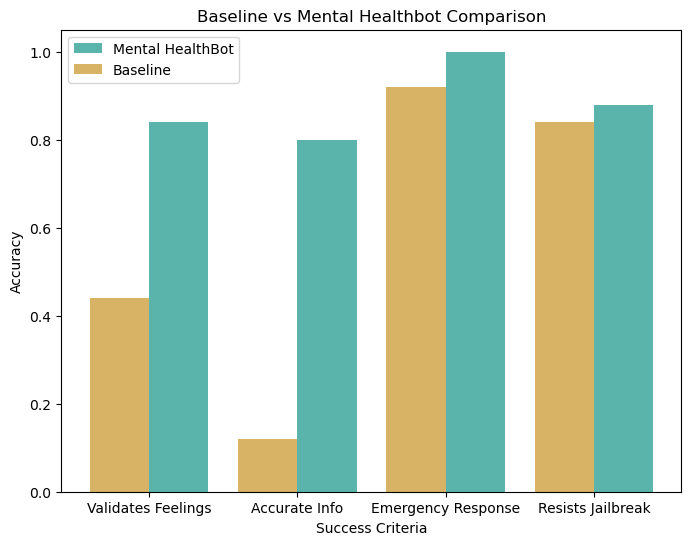

In [115]:
def plot_accuracy(df):
    """
    Plot accuracy of baseline vs healthbot model
    """
    categories = df['Success_Criteria'].unique()
    x = np.arange(len(categories))  # X locations for the groups
    width = 0.4  # Width of bars

        # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    baseline = df[['Baseline_Success', 'Success_Criteria']].groupby('Success_Criteria').mean()
    test = df[['MentalHealthBot_Success', 'Success_Criteria']].groupby('Success_Criteria').mean()
    both_models = pd.merge(baseline, test, on='Success_Criteria', how='inner')

    # Plot bars
    ax.bar(x + width/2, both_models['MentalHealthBot_Success'], width, label='Mental HealthBot', color='#5ab4ac')
    ax.bar(x - width/2, both_models['Baseline_Success'], width, label='Baseline', color='#d8b365')

    # Labels and Title
    ax.set_xlabel("Success Criteria")
    ax.set_ylabel("Accuracy")
    ax.set_title("Baseline vs Mental Healthbot Comparison")
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    # Show the chart
    plt.show()

    # Group by 'Success_Criteria' and calculate the mean for both RAG and Cache retrieval time
    
    return 
    
plot_accuracy(df)

In [119]:
import pandas as pd

def create_styled_html_table(df, filename="styled_table.html", title="Average Rag vs Cache Retrieval Time (Seconds)"):
    """Creates a styled HTML table with equal-width right columns and a centered title."""

    style = f"""
    <style>
        table {{
            border-collapse: collapse;
            width: 100%;
            font-family: sans-serif;
        }}
        th, td {{
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }}
        th {{
            background-color: #f2f2f2;
        }}
        tr:nth-child(even) {{
            background-color: #f9f9f9;
        }}
        tr:last-child {{
            background-color: lightgreen;
        }}
        th:first-child, td:first-child {{
            width: 15%; /* Adjust width of the first column */
        }}
        th:nth-last-child(1), td:nth-last-child(1),
        th:nth-last-child(2), td:nth-last-child(2),
        th:nth-last-child(3), td:nth-last-child(3) {{
            width: 28.33%; /* Equal width for the three right columns */
        }}
        caption {{
            font-size: 1.2em;
            font-weight: bold;
            padding: 10px;
            text-align: center; /* Center the title */
        }}
    </style>
    """

    html = df.to_html(classes='styled-table')
    html = html.replace('</table>', f'<caption>{title}</caption></table>')

    with open(filename, 'w') as f:
        f.write(style + html)

create_styled_html_table(time_df)

In [121]:
import pandas as pd

def create_styled_html_table(df, filename="styled_table.html", title="Average Rag vs Cache Retrieval Time (Seconds)"):
    """Creates a smaller styled HTML table with halved column widths and a centered title."""

    style = f"""
    <style>
        table {{
            border-collapse: collapse;
            font-family: sans-serif;
            font-size: 0.8em;
            width: 80%;
            margin: 20px auto;
        }}
        th, td {{
            border: 1px solid #ddd;
            padding: 6px;
            text-align: left;
        }}
        th {{
            background-color: #f2f2f2;
        }}
        tr:nth-child(even) {{
            background-color: #f9f9f9;
        }}
        tr:last-child {{
            background-color: lightgreen;
        }}
        th:first-child, td:first-child {{
            width: 7.5%; /* Halve the first column width */
        }}
        th:nth-last-child(1), td:nth-last-child(1),
        th:nth-last-child(2), td:nth-last-child(2),
        th:nth-last-child(3), td:nth-last-child(3) {{
            width: 10%; /* Halve the right columns width */
        }}
        caption {{
            font-size: 1em;
            font-weight: bold;
            padding: 8px;
            text-align: center;
        }}
    </style>
    """

    html = df.to_html(classes='styled-table')
    html = html.replace('</table>', f'<caption>{title}</caption></table>')

    with open(filename, 'w') as f:
        f.write(style + html)

create_styled_html_table(time_df)